In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from entropy import spectral_entropy

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import Audio

import keras

In [2]:
Ravdess = "/home/kenterbery/projects/speech_emotion_recognition/input/Ravdess/audio_speech_actors_01-24/"
Crema = "/home/kenterbery/projects/speech_emotion_recognition/input/Crema/"
Savee = "/home/kenterbery/projects/speech_emotion_recognition/input/Savee/"
Tess = "/home/kenterbery/projects/speech_emotion_recognition/input/Tess/"

Ravdess dataset

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, Ravdess + dir + "/" + wav))

In [4]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [5]:
Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotion                                               Path
0  neutral  /home/kenterbery/projects/speech_emotion_recog...
1  neutral  /home/kenterbery/projects/speech_emotion_recog...
2  disgust  /home/kenterbery/projects/speech_emotion_recog...
3  disgust  /home/kenterbery/projects/speech_emotion_recog...
4  disgust  /home/kenterbery/projects/speech_emotion_recog...

Crema dataset


In [6]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + wav))
    else:
        emotion_df.append(("unknown", Crema + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

Emotion                                               Path
0  disgust  /home/kenterbery/projects/speech_emotion_recog...
1    happy  /home/kenterbery/projects/speech_emotion_recog...
2      sad  /home/kenterbery/projects/speech_emotion_recog...
3    happy  /home/kenterbery/projects/speech_emotion_recog...
4  neutral  /home/kenterbery/projects/speech_emotion_recog...

TESS dataset

In [7]:
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(Tess + dir):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", Tess + dir + "/" + wav))
        else:
            emotion_df.append((emo, Tess + dir + "/" + wav))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

Emotion                                               Path
0     sad  /home/kenterbery/projects/speech_emotion_recog...
1     sad  /home/kenterbery/projects/speech_emotion_recog...
2     sad  /home/kenterbery/projects/speech_emotion_recog...
3     sad  /home/kenterbery/projects/speech_emotion_recog...
4     sad  /home/kenterbery/projects/speech_emotion_recog...

In [8]:
savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion = re.split(r"[0-9]", info)[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + wav))
    else:
        emotion_df.append(("surprise", Savee + wav))


Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()

Emotion                                               Path
0      sad  /home/kenterbery/projects/speech_emotion_recog...
1  neutral  /home/kenterbery/projects/speech_emotion_recog...
2  disgust  /home/kenterbery/projects/speech_emotion_recog...
3    angry  /home/kenterbery/projects/speech_emotion_recog...
4  disgust  /home/kenterbery/projects/speech_emotion_recog...

In [9]:
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df.shape

(12162, 2)

In [10]:
df.head()

Emotion                                               Path
0  neutral  /home/kenterbery/projects/speech_emotion_recog...
1  neutral  /home/kenterbery/projects/speech_emotion_recog...
2  disgust  /home/kenterbery/projects/speech_emotion_recog...
3  disgust  /home/kenterbery/projects/speech_emotion_recog...
4  disgust  /home/kenterbery/projects/speech_emotion_recog...

### Exploratory data analysis


In [11]:
%matplotlib inline

plt.style.use("ggplot")

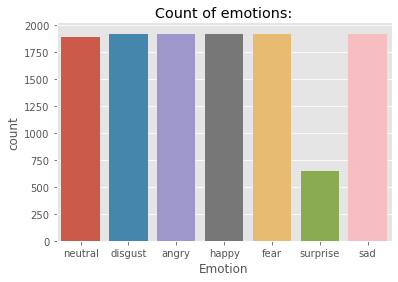

In [12]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [13]:
def create_waveplot(data, sr, emo):
    plt.figure(figsize=(10,3))
    plt.title(f"Waveplot for .wav with {emo} emotion")
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, emo):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12,3))
    plt.title(f"Spectrogram for .wav with {emo} emotion")
    librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="hz")
    # librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar()


/home/kenterbery/anaconda3/envs/speech_emotion_recognition/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


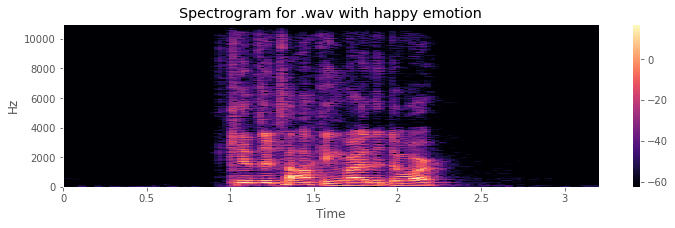

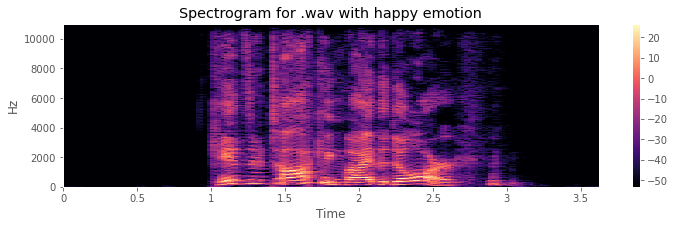

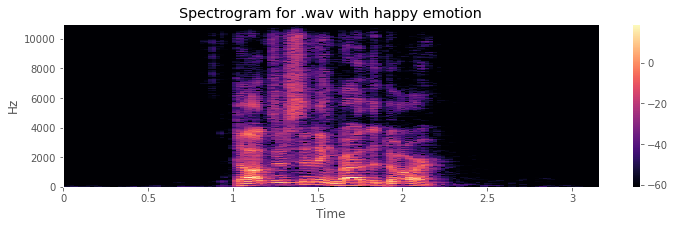

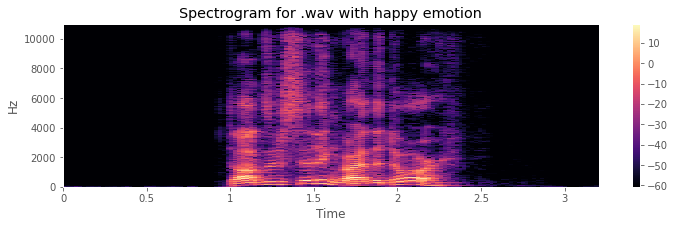

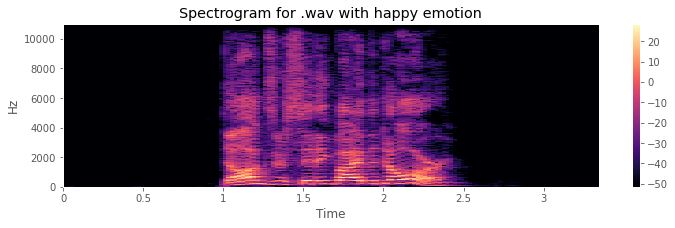

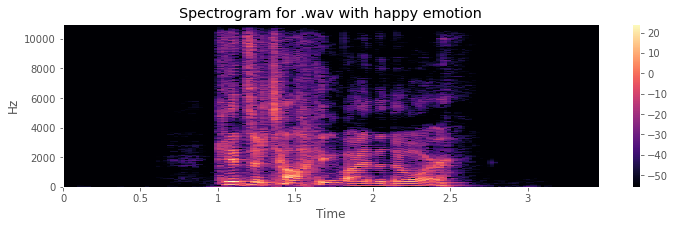

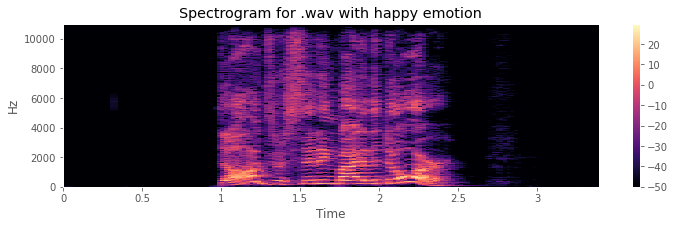

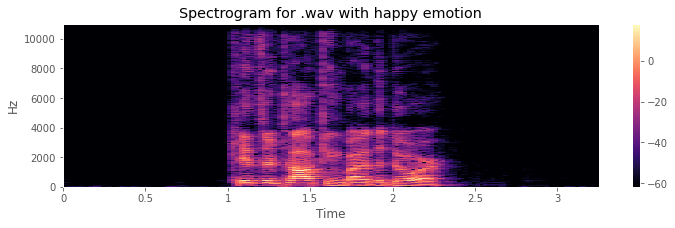

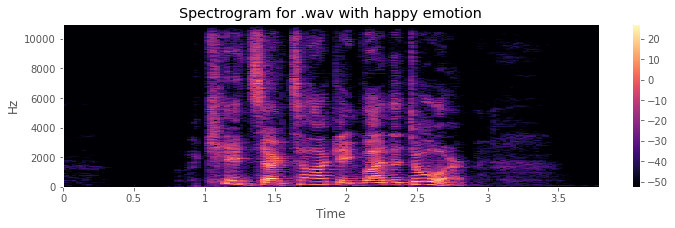

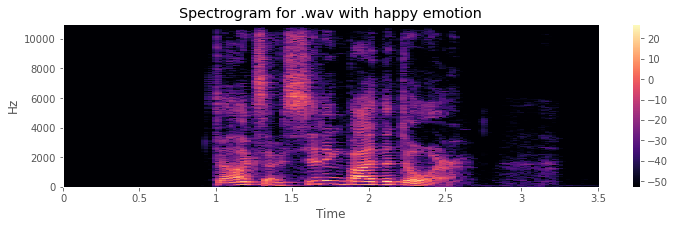

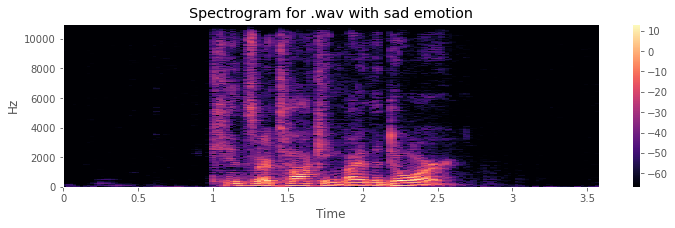

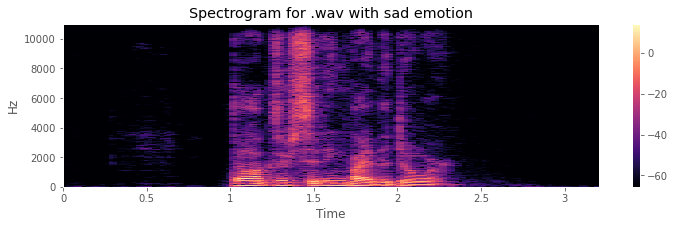

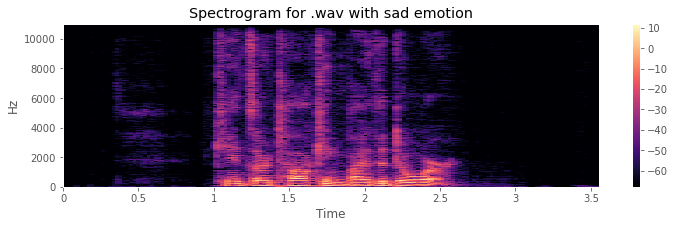

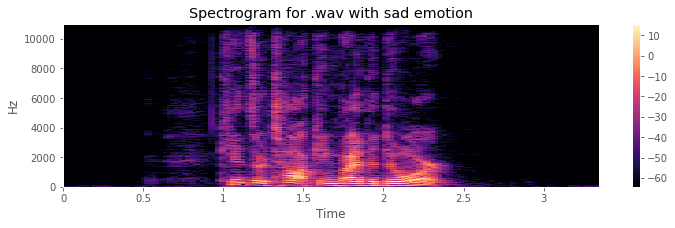

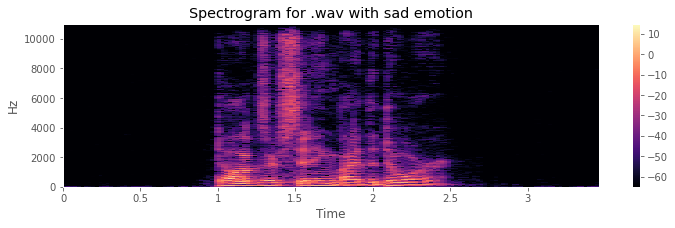

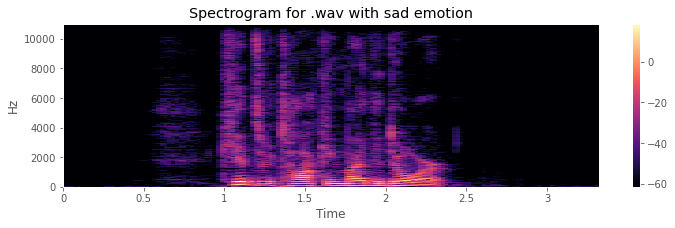

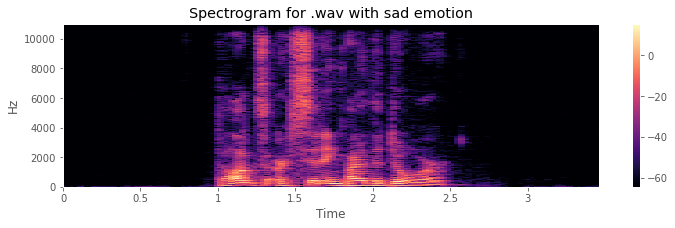

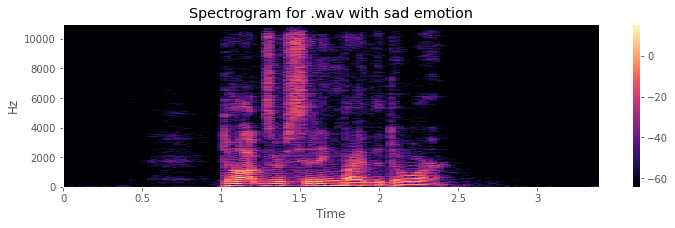

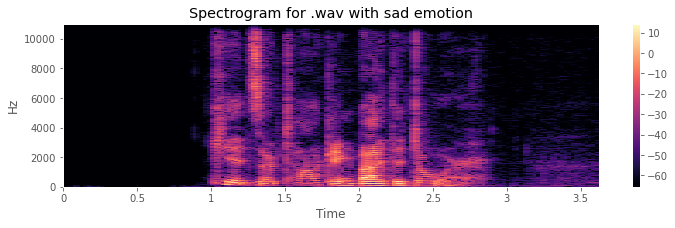

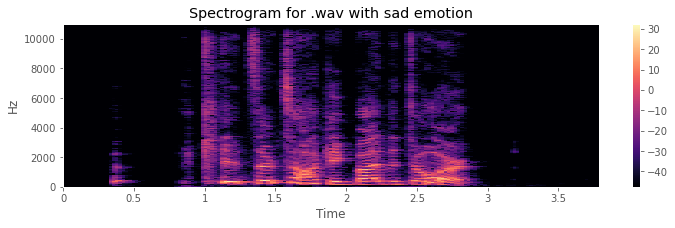

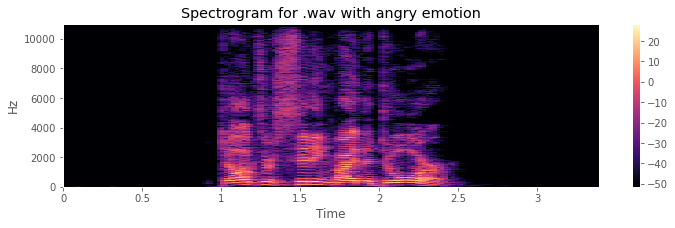

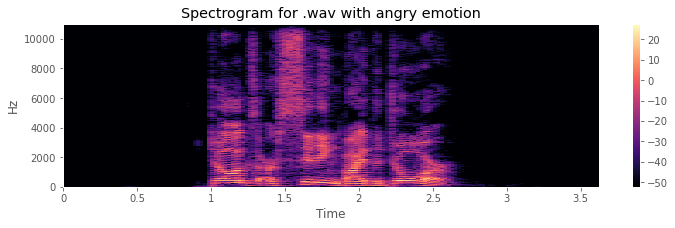

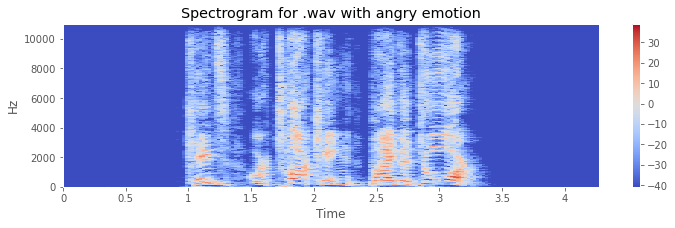

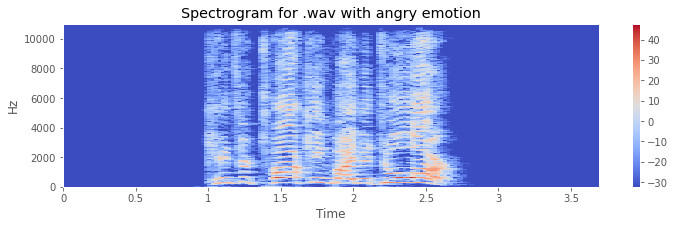

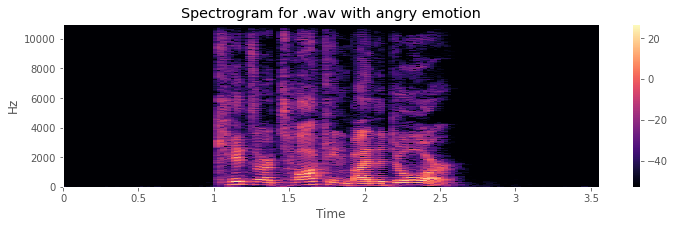

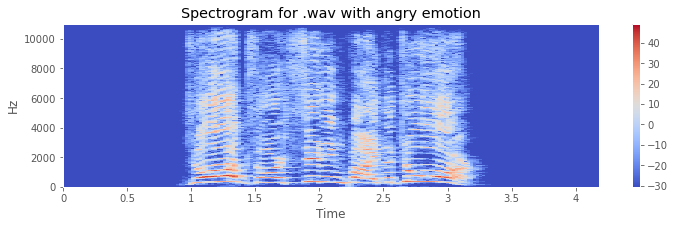

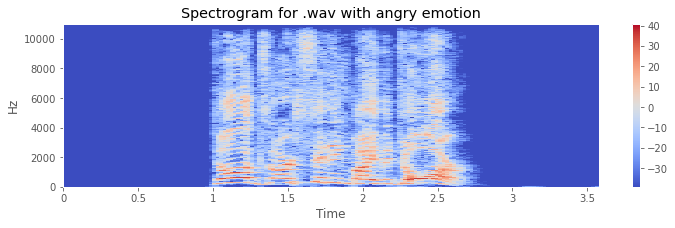

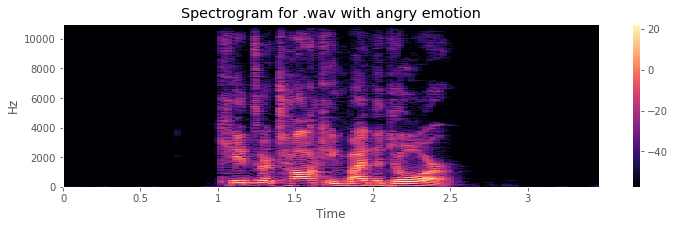

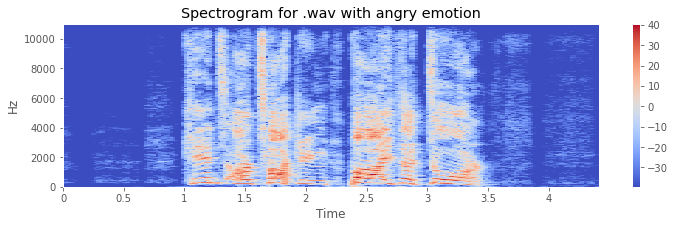

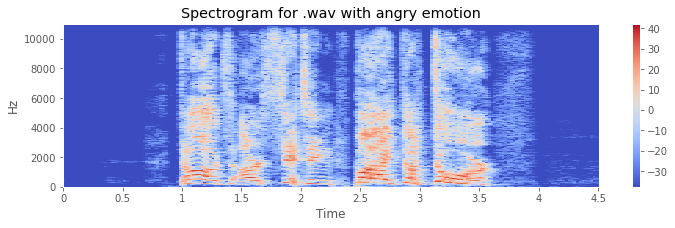

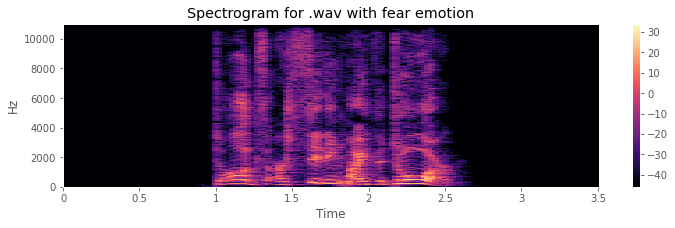

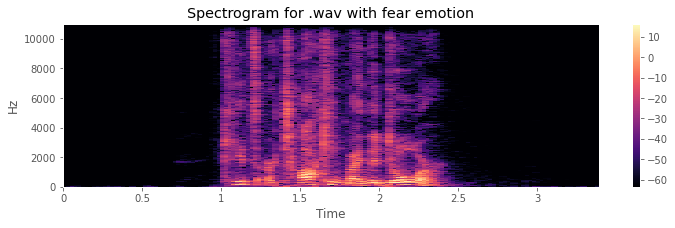

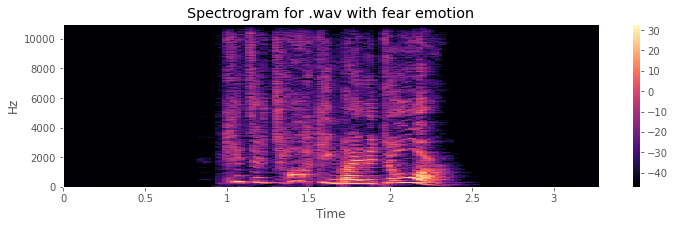

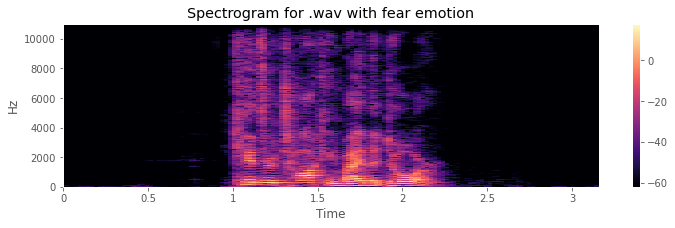

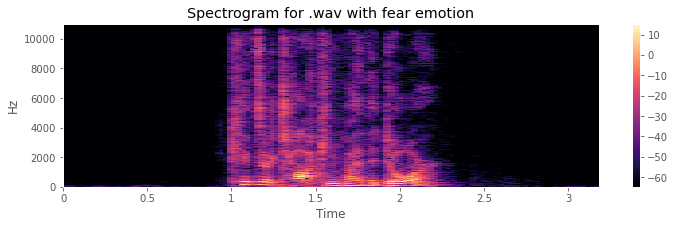

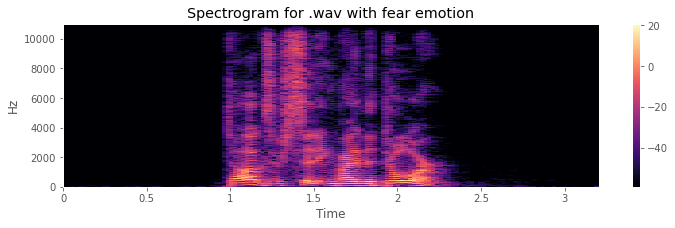

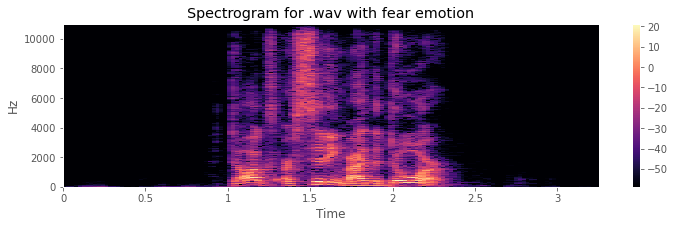

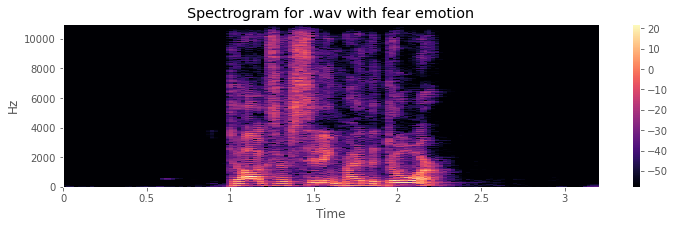

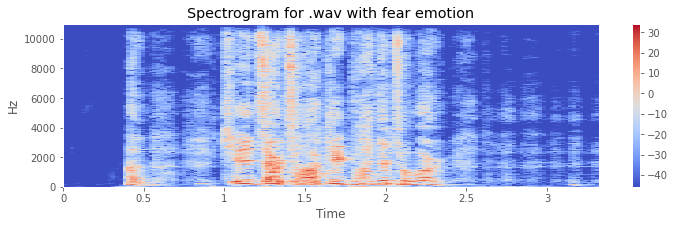

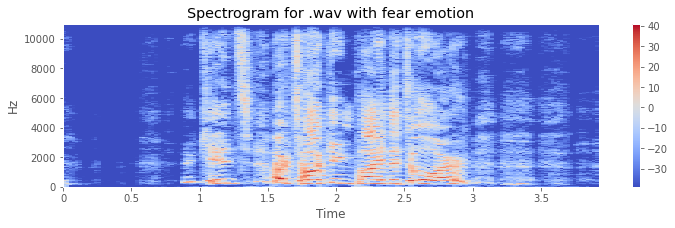

In [14]:
emotions = ["happy", "sad",  "angry", "fear"]
for emotion in emotions:
    for i in range(10):
        path = np.array(df["Path"][df["Emotion"] == emotion])[i]
        data, sampling_rate = librosa.load(path)
        # create_waveplot(data, sampling_rate, emotion)
        create_spectrogram(data, sampling_rate, emotion)
        # Audio(path)

### Data augmentation

In [15]:
def noise(data, rate=0.035):
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [16]:
path = np.array(df.Path)[100]
data, sampling_rate = librosa.load(path)

1. Simple audio

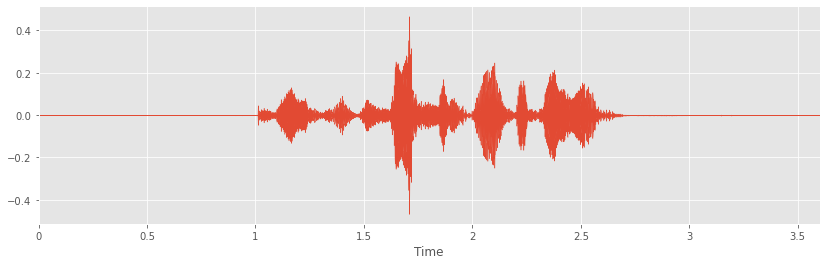

In [17]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate)
Audio(path)

2. Noised audio

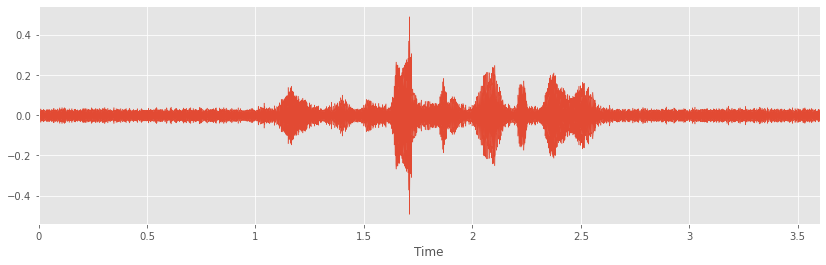

In [18]:
noised_data = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)


3. Stretching


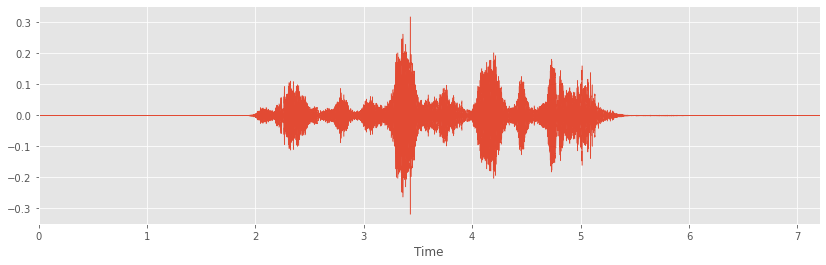

In [19]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)

4. Shifting


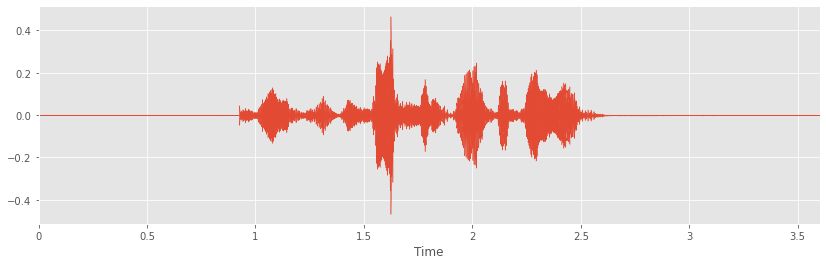

In [20]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)


5. Pitching

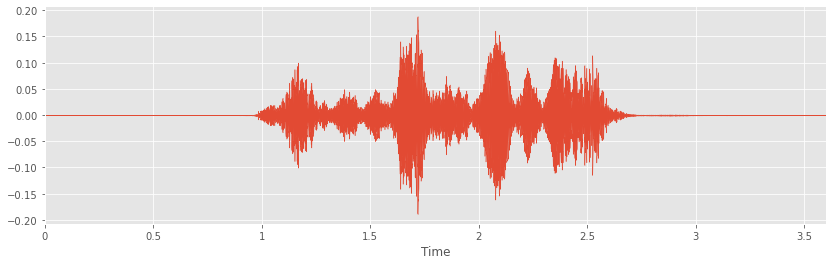

In [21]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

For data augmentation we will use noise, shift and pitch


### Feature extraction

#### Features which may be useful:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
3. Spectral Centroid : The center of gravity of the spectrum.
4. Spectral Spread : The second central moment of the spectrum.
5. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
6. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
7. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
8. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [22]:
n_fft = 2048
hop_length = 512

In [23]:
def chunks(data, frame_length, hop_length):
    """
    Split data to chunks with size frame_length and every hop_length.
    :param data: np.array
    :param frame_length: Int
    :param hop_length: Int
    :return: <generator>
    """
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


def spc_entropy(data, sr):
    spc_en = spectral_entropy(data, sf=sr, method="fft")
    return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_delta_x = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_delta_x, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T)


def mfcc(data, sr, frame_length=2048, hop_length=512):
    mfcc_ = librosa.feature.mfcc(data, sr)
    return np.squeeze(mfcc_.T)

#### Let's check data formats:

In [24]:
path = np.array(df["Path"])[1]
data, sample_rate = librosa.load(path)
data

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        6.4757756e-07, -2.8374080e-07,  0.0000000e+00], dtype=float32)

In [25]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (136,)
Energy:  (136,)
Entropy of Energy : (136,)
RMS : (136,)
Spectral Centroid : (136,)
Spectral Entropy:  ()
Spectral Flux:  ()
Spectral Rollof:  (136,)
Chroma STFT:  (136, 12)
MelSpectrogram:  (136, 128)
MFCC:  (136, 20)


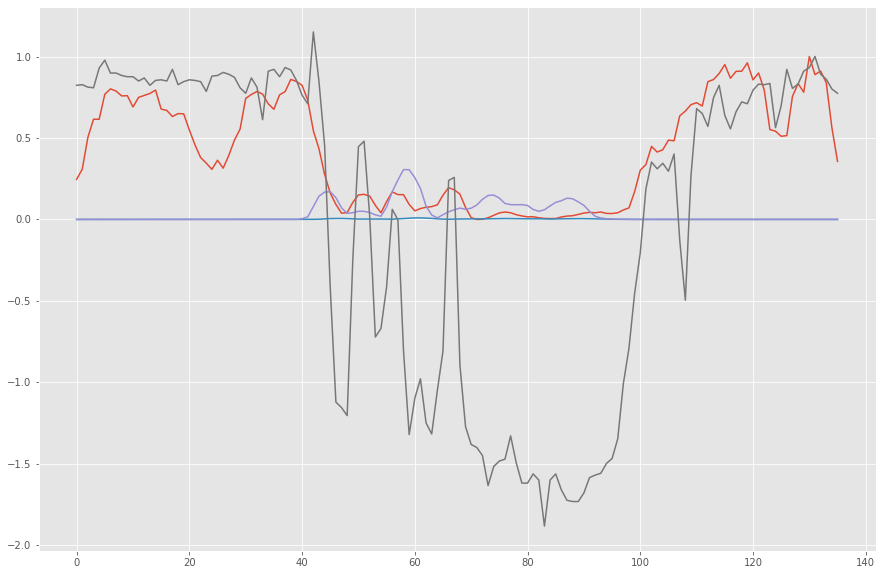

In [26]:
# sns.histplot(x=np.linspace(0,12, 12), y=np.mean(chroma_stft(data, sampling_rate), axis=0))
zcr_data = zcr(data)
spc_rollof_data = spc_rollof(data, sampling_rate)
plt.figure(figsize=(15,10))
plt.plot(((zcr_data - zcr_data.min()) / (zcr_data.max() - zcr_data.min())))
# plt.plot(energy(data))
plt.plot(rmse(data))
plt.plot(entropy_of_energy(data))
plt.plot((spc_rollof_data - spc_rollof_data.mean()) / spc_rollof_data.std() )

# plt.bar(range(zcr(data).shape[0]), zcr(data))
Audio(path)


In [27]:
zcr_data = ( zcr_data - zcr_data.min()) / (zcr_data.max() - zcr_data.min())
energy_data = energy(data)
rmse_data = rmse(data)
entropy_of_energy_data = entropy_of_energy(data)
spc_rollof_data = (spc_rollof_data - spc_rollof_data.mean()) / spc_rollof_data.std()

# result = np.array([])
# result = np.hstack((result, zcr_data))
# result = np.hstack((result, energy_data))
# result = np.hstack((result, rmse_data))
# result = np.hstack((result, entropy_of_energy_data))
# result = np.hstack((result, spc_rollof_data))

data_frame = pd.DataFrame({
    "ZCR" : zcr_data,
    "Energy" : energy_data,
    "RMS" : rmse_data,
    "Entropy" : entropy_of_energy_data,
    "Rollof" : spc_rollof_data
})
data_frame.head(10)

ZCR        Energy       RMS       Entropy    Rollof
0  0.246263  1.917346e-10  0.000009  4.183550e-06  0.823636
1  0.308419  1.597946e-10  0.000015  3.527649e-06  0.827406
2  0.504327  1.582226e-10  0.000014  3.495148e-06  0.812326
3  0.615264  4.150442e-11  0.000013  9.950664e-07  0.808556
4  0.615264  6.015397e-11  0.000013  1.410745e-06  0.929200
5  0.768686  6.362170e-11  0.000006  1.487049e-06  0.978212
6  0.801731  1.512197e-10  0.000008  3.350095e-06  0.899039
7  0.788356  1.592529e-10  0.000008  3.516451e-06  0.899039
8  0.758458  1.763552e-10  0.000012  3.868749e-06  0.883958
9  0.760031  1.871011e-10  0.000013  4.088895e-06  0.876418

In [28]:
data_frame.describe()

ZCR        Energy         RMS       Entropy        Rollof
count  136.000000  1.360000e+02  136.000000  1.360000e+02  1.360000e+02
mean     0.417452  7.531376e-06    0.001569  3.797773e-02  5.224579e-17
std      0.327343  1.540348e-05    0.002260  6.407559e-02  1.003697e+00
min      0.000000  2.998955e-13    0.000006  9.272497e-09 -1.883322e+00
25%      0.073171  2.208788e-10    0.000015  4.775353e-06 -1.104788e+00
50%      0.420928  1.243040e-09    0.000035  2.380830e-05  5.672669e-01
75%      0.751180  9.254408e-06    0.003042  6.135036e-02  8.471995e-01
max      1.000000  8.891033e-05    0.009429  3.060788e-01  1.151638e+00

In [29]:
    emotions = df.Emotion
for emotion in emotions.unique():
    energy_emo = np.array([])
    rms_emo = np.array([])
    for i in range(0, 10):
        path = np.array(df["Path"][df["Emotion"] == emotion])[i]
        data, sample_rate = librosa.load(path)
        energy_emo = np.append(energy_emo, energy(data))
        rms_emo = np.append(rms_emo, rmse(data))
    plt.figure(figsize=(5,5))
    plt.title(f"RMS to Energy for .wav with {emotion} emotion")
    sns.scatterplot(y=energy_emo, x=rms_emo, palette=emotion)


IndentationError: expected an indented block (<ipython-input-29-6eb6796c7ad5>, line 3)